In [1]:
import pandas as pd
import numpy as np
import matplotlib as plt

# Data loading

In [3]:
path_to_data = 'datasets/raw/data/'

In [4]:
# benchmark files checking
all_files=[]
import os
for root, dirs, files in os.walk(path_to_data):
    for file in files:
        if file.endswith(".csv"):
             all_files.append(os.path.join(root, file))



# datasets with anomalies loading
list_of_df = [pd.read_csv(file, 
                          sep=';', 
                          index_col='datetime', 
                          parse_dates=True) for file in all_files if 'anomaly-free' not in file]

list_of_df = [df.drop(columns=['changepoint']) for df in list_of_df]
# anomaly-free df loading
anomaly_free_df = pd.read_csv([file for file in all_files if 'anomaly-free' in file][0], 
                            sep=';', 
                            index_col='datetime', 
                            parse_dates=True)

In [6]:
# dataset characteristics printing
print('SKAB v0.9')
print(f'- A number of datasets: {len(list_of_df)}')
print(f'- Shape of the random dataset: {list_of_df[10].shape}')
n_outlier = sum([len(df[df.anomaly==1.]) for df in list_of_df])
print(f'- A number of outliers (point anomalies): {n_outlier}\n')
print(f'Head of the random dataset:')
display(list_of_df[0].head(1))

SKAB v0.9
- A number of datasets: 34
- Shape of the random dataset: (1147, 9)
- A number of outliers (point anomalies): 13067

Head of the random dataset:


,Accelerometer1RMS,Accelerometer2RMS,Current,Pressure,Temperature,Thermocouple,Voltage,Volume Flow RateRMS,anomaly
datetime,,,,,,,,,
2020-03-01 15:44:06,0.082065,0.133521,1.27794,0.054711,92.2562,22.2577,209.639,76.0197,0.0


# Data visualization

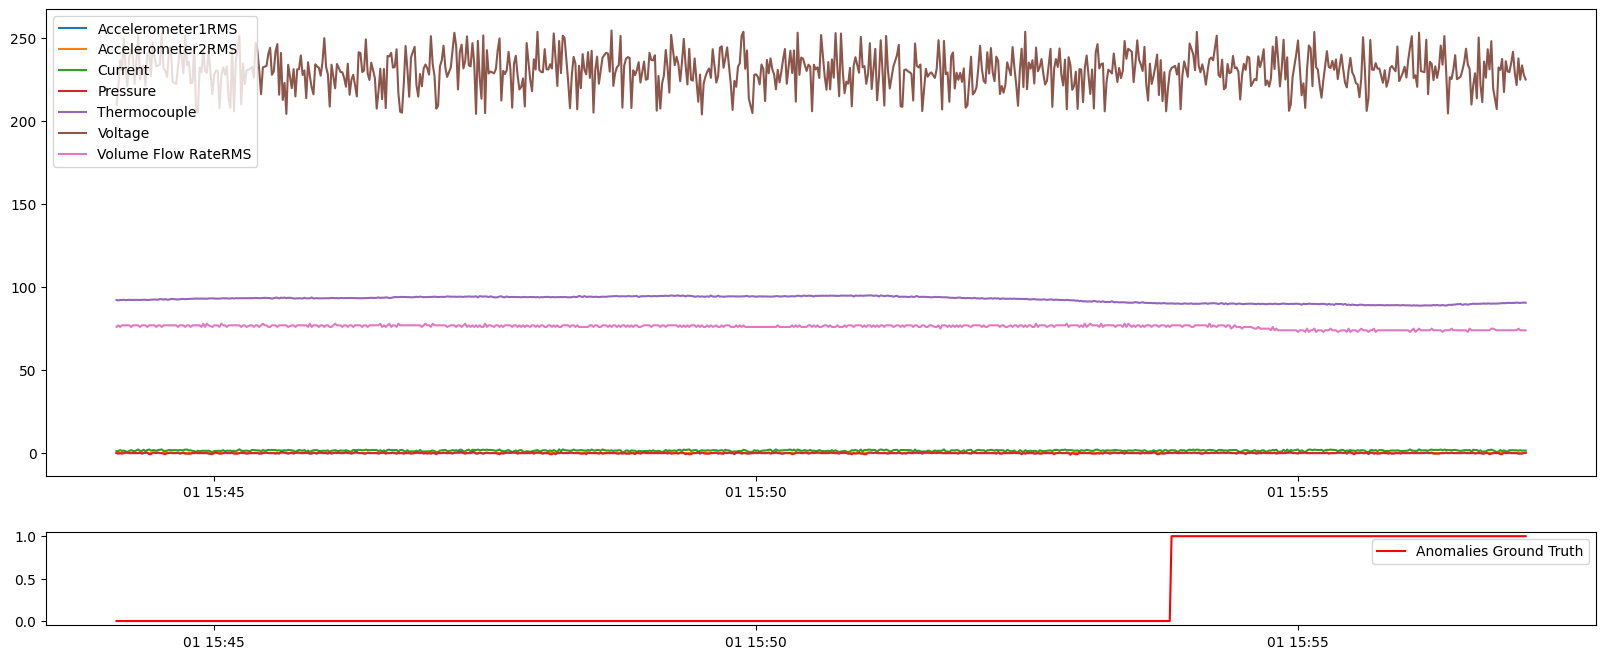

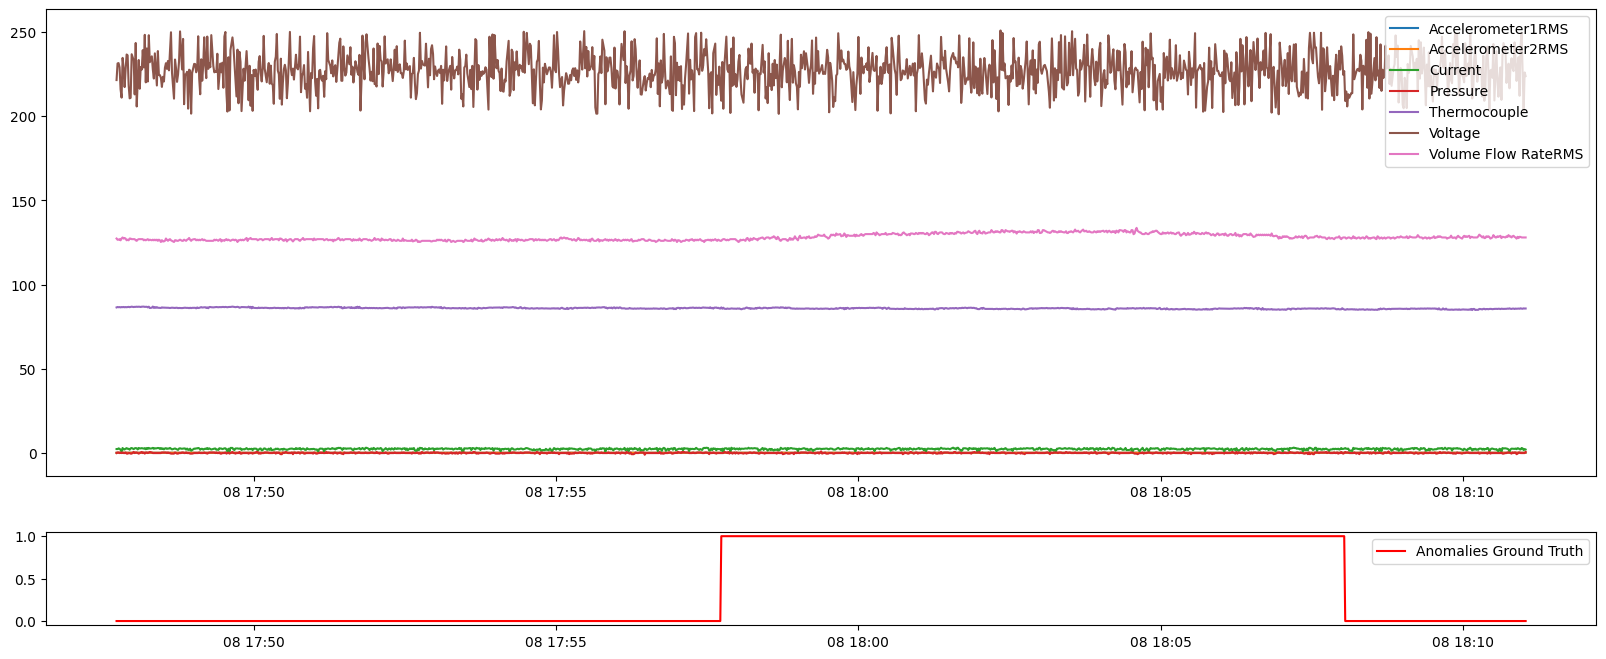

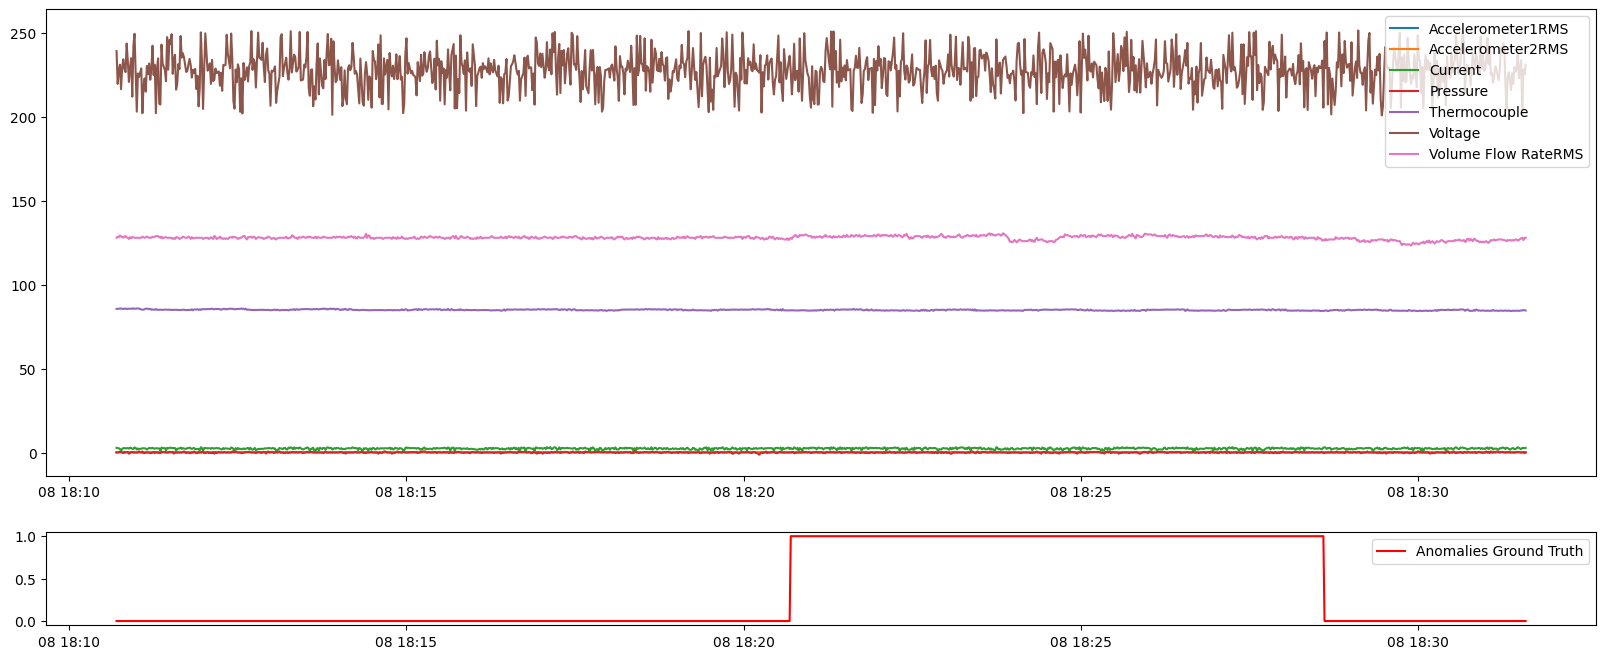

In [7]:
from plot_data import plot_skab

plot_skab(list_of_df[0].drop(columns=['anomaly']), list_of_df[0].anomaly)

plot_skab(list_of_df[1].drop(columns=['anomaly']), list_of_df[1].anomaly)

plot_skab(list_of_df[2].drop(columns=['anomaly']), list_of_df[2].anomaly)

# Anomaly detection

In [8]:
from tensorflow import keras
from keras import layers
import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf

class DenseAE(tf.keras.Model):
    def __init__(self, net_layers, internal_act, output_act, dropout_rate, optimizer, loss):
        super().__init__()
        encoder_layers = []
        decoder_layers = []

        for i in range(len(net_layers)-1):
            encoder_layers.append(layers.Dense(net_layers[i], activation=internal_act))
            encoder_layers.append(layers.Dropout(dropout_rate))
        encoder_layers.append(layers.Dense(net_layers[-1], activation=internal_act))

        for i in range(len(net_layers)-2, 0, -1):
            decoder_layers.append(layers.Dense(net_layers[i], activation=internal_act))
            decoder_layers.append(layers.Dropout(dropout_rate))
        decoder_layers.append(layers.Dense(net_layers[0], activation=output_act))
        
        self.encoder = tf.keras.Sequential(encoder_layers)
        self.decoder = tf.keras.Sequential(decoder_layers)

        self.compile(optimizer=optimizer, loss=loss)

        self.threshold = None
        self.loss_max = None
        self.hist = None

    def call(self, inputs):
        encoded = self.encoder(inputs)
        decoded = self.decoder(encoded)
        return decoded

    def train(self, train_data, epochs=50, batch_size=128):
        hist = self.fit(
            train_data,
            train_data,
            epochs=epochs,
            batch_size=batch_size,
            validation_split=0.1,
            verbose=0
            )
        self.hist = {'loss': hist.history['loss'], 'val_loss': hist.history['val_loss']}
        self.calculate_parameters(train_data)

    def plot_train_history(self):
        plt.plot(self.hist["loss"], label="Training Loss")
        plt.plot(self.hist["val_loss"], label="Validation Loss")
        plt.legend()
        plt.show()

    def calculate_parameters(self, data):
        reconstructions = self.predict(data)
        train_loss = tf.keras.losses.mae(reconstructions, data)
        threshold = np.mean(train_loss) + np.std(train_loss)
        loss_max = np.max(train_loss)
        self.threshold, self.loss_max = threshold, loss_max

    def detect_anomalies(self, test_data):
        recons = self.predict(test_data)
        loss = tf.keras.losses.mae(recons, test_data)
        loss = np.array(loss)
        return np.array(loss > self.threshold).astype(int)
    

13/13 [==============================] - 0s 914us/step


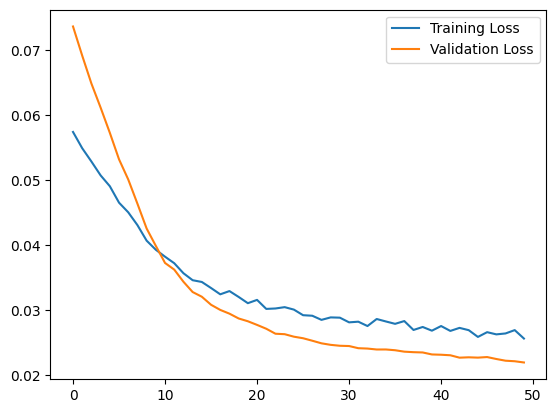

In [26]:
from sklearn.preprocessing import StandardScaler, MinMaxScaler

scaler = MinMaxScaler()

df = list_of_df[0]

X = scaler.fit_transform(df[:400].drop(columns=['anomaly']))

detector = DenseAE([8, 32, 16, 32, 8], 'elu', 'sigmoid', 0.1, 'rmsprop', 'mse')

detector.train(X)
detector.plot_train_history()

36/36 [==============================] - 0s 880us/step


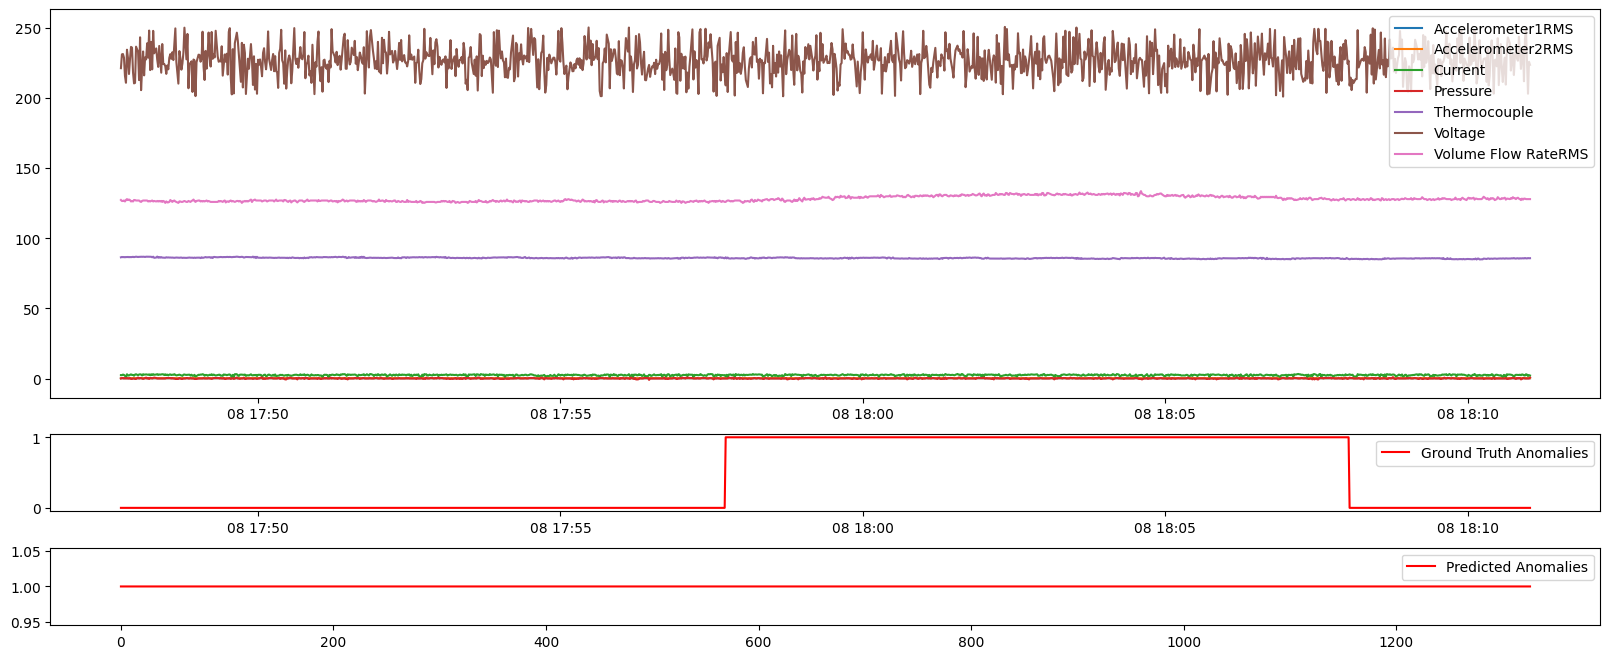

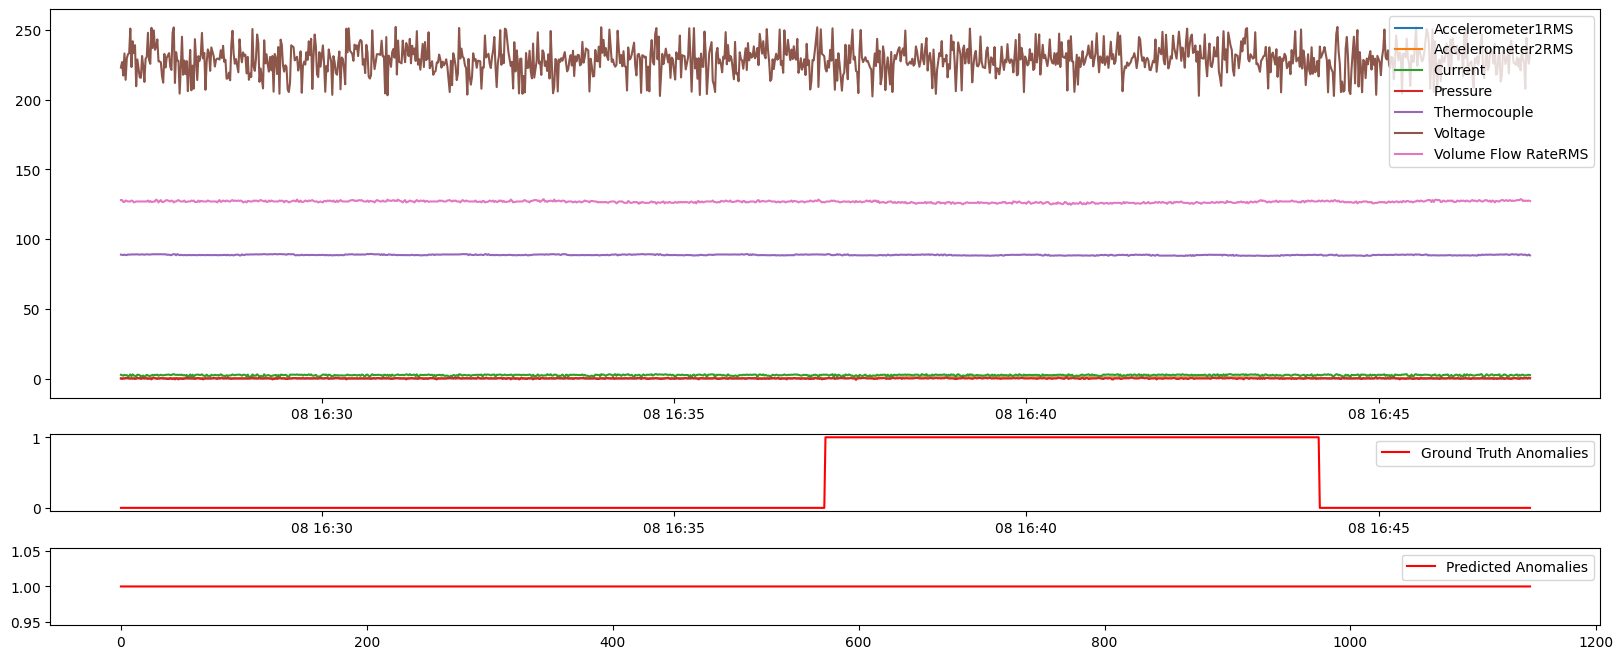

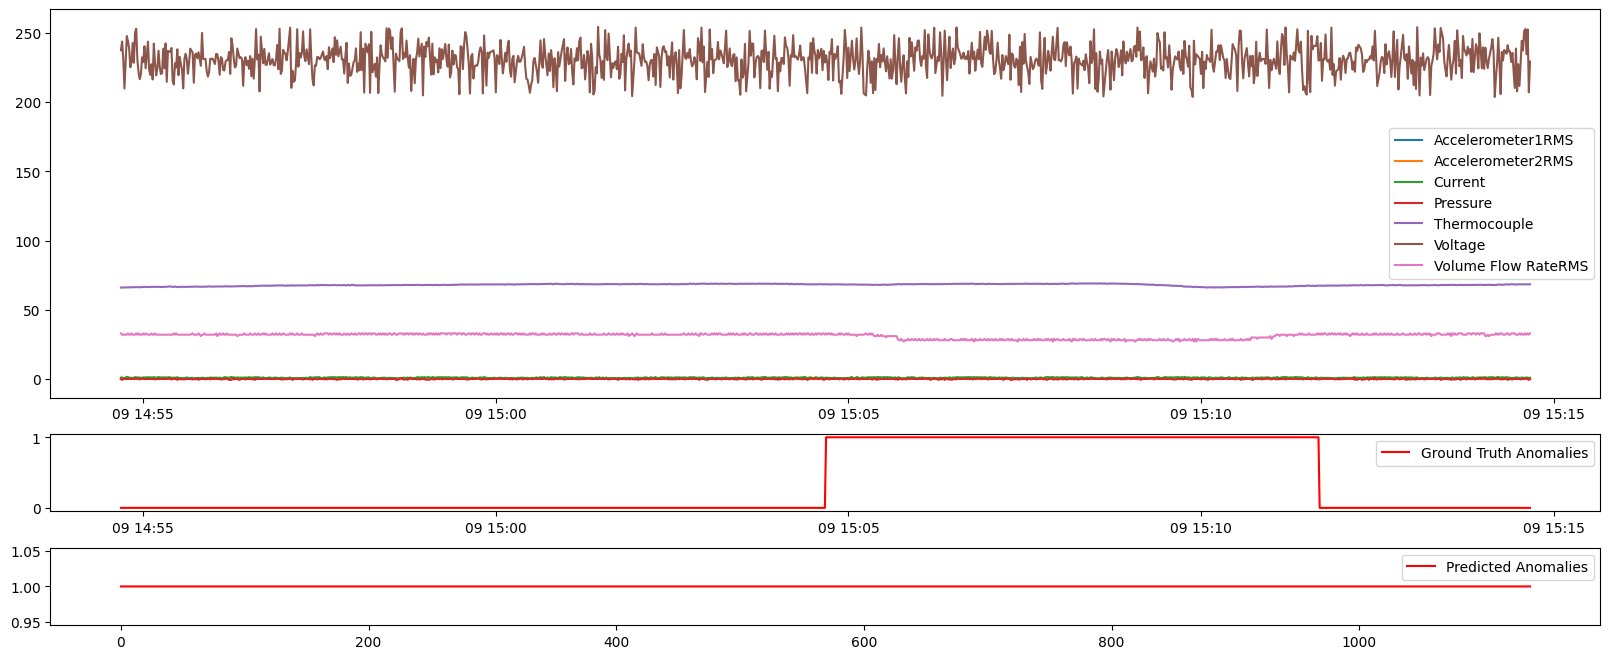

In [27]:
anomalies1 = detector.detect_anomalies(scaler.transform(list_of_df[1].drop(columns=['anomaly'])))
anomalies2 = detector.detect_anomalies(scaler.transform(list_of_df[10].drop(columns=['anomaly'])))
anomalies3 = detector.detect_anomalies(scaler.transform(list_of_df[20].drop(columns=['anomaly'])))

plot_skab(list_of_df[1].drop(columns=['anomaly']), list_of_df[1].anomaly, anomalies1)
plot_skab(list_of_df[10].drop(columns=['anomaly']), list_of_df[10].anomaly, anomalies2)
plot_skab(list_of_df[20].drop(columns=['anomaly']), list_of_df[20].anomaly, anomalies3)